In [777]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

Nu_of_conflicts =100 # Number of conflicts 10*2=20
Rows = 4
Colums = 4
group_size =2
Nof_users = Rows * Colums



In [778]:
class SinkhornNet(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(SinkhornNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = x.view(-1, Nof_users, Nof_users)
        x = torch.sigmoid(x)  # Apply sigmoid activation to squash values between 0 and 1
        return x

# Adding Noise to the Weights
def add_noise_to_weights(model, noise_factor):
    for param in model.parameters():
        noise = torch.randn_like(param) * noise_factor
        param.data += noise


In [779]:

def print_person_seat_assignments(model_output, threshold=0.5):
    """
    Prints the person-seat assignments based on the output tensor from the model.

    Args:
        model_output (torch.Tensor): The output tensor from the model.
        threshold (float, optional): The threshold value for binarizing the output tensor. Default is 0.5.

    Returns:
        None
    """
    # Reshape the output to a 3D tensor
    reshaped_output = model_output.view(1, Nof_users, Nof_users)

    # Apply thresholding to obtain a binary permutation matrix
    binary_perm_matrix = (reshaped_output > threshold).float()

    # Initialize the person-seat assignments list
    person_seat_assignments = []

    # Iterate over rows and collect person-seat assignments
    for row_idx, row in enumerate(binary_perm_matrix[0]):
        for seat_idx, value in enumerate(row):
            if value == 1:
                person_seat_assignments.append((row_idx, seat_idx))

    # Print the person-seat assignments
#    for person, seat in person_seat_assignments:
#        print(f"Person {person} - Seat {seat}")

    return person_seat_assignments

In [780]:
import torch

def custom_loss(output, pairwise_conflicts, seat_rows=4, seat_cols=6, high_importance=20.0, groups=None, group_penalty=0.2, conflict_penalty=1):
    """
    Custom loss function to evaluate the seating arrangement.

    Args:
    - output (torch.Tensor): Output tensor of shape (batch_size, n_persons, n_seats).
                             Each element represents the assignment probability of a person to a seat.
    - pairwise_conflicts (torch.Tensor): Conflict matrix of shape (n_persons, n_persons).
                                         Each element is 1 if the corresponding persons have a conflict, else 0.
    - seat_rows (int): Number of rows in the seating arrangement.
    - seat_cols (int): Number of columns in the seating arrangement.
    - high_importance (float): Factor to give higher importance to person-seat assignment constraints.
    - groups (list of lists): A list of lists where each inner list contains indices of persons in the same group.
    - group_penalty (float): Penalty for each neighbor who is not a group mate.
    - conflict_penalty (float): Penalty factor for conflicts.

    Returns:
    - torch.Tensor: Calculated loss based on seat assignment constraints and conflicts.
    """
    batch_size, n_persons, n_seats = output.size()

    assert n_persons == seat_rows * seat_cols, f"Number of persons ({n_persons}) must be equal to the total number of seats ({seat_rows * seat_cols})"
    assert n_seats == seat_rows * seat_cols, f"Number of seats ({n_seats}) must match seat rows * seat cols ({seat_rows * seat_cols})"
    assert isinstance(groups, list) and all(isinstance(group, list) for group in groups), "Groups must be a list of lists"

    # Ensure each person gets a unique seat (rows should sum to 1)
    row_sum_loss = torch.sum((torch.sum(output, dim=2) - 1) ** 2) * high_importance

    # Ensure each seat is assigned to only one person (columns should sum to 1)
    col_sum_loss = torch.sum((torch.sum(output, dim=1) - 1) ** 2) * high_importance

    # Initialize conflict loss
    conflict_loss = 0

    # Initialize group mate loss
    group_mate_loss = 0

    # Reshape the output to match the seating arrangement dimensions
    output_reshaped = output.view(batch_size, seat_rows, seat_cols, n_persons)

    # Create a dictionary to map persons to their groups
    person_to_group = {}
    for group_idx, group in enumerate(groups):
        for person in group:
            person_to_group[person] = group_idx

    # Iterate over each seat in the seating arrangement
    for i in range(seat_rows):
        for j in range(seat_cols):
            person_idx = i * seat_cols + j  # Index of the person in the original flat tensor
            person_prob = output_reshaped[:, i, j, :]  # Probability distribution of the person in the seat

            neighbors = []
            if i > 0:  # Up
                neighbor_up_idx = (i - 1) * seat_cols + j
                neighbor_up_prob = output_reshaped[:, i - 1, j, :]
                conflict_loss += torch.sum(person_prob * neighbor_up_prob * (pairwise_conflicts[person_idx, neighbor_up_idx] == 1).float() * conflict_penalty)
                neighbors.append(neighbor_up_idx)
            if i < seat_rows - 1:  # Down
                neighbor_down_idx = (i + 1) * seat_cols + j
                neighbor_down_prob = output_reshaped[:, i + 1, j, :]
                conflict_loss += torch.sum(person_prob * neighbor_down_prob * (pairwise_conflicts[person_idx, neighbor_down_idx] == 1).float() * conflict_penalty)
                neighbors.append(neighbor_down_idx)
            if j > 0:  # Left
                neighbor_left_idx = i * seat_cols + (j - 1)
                neighbor_left_prob = output_reshaped[:, i, j - 1, :]
                conflict_loss += torch.sum(person_prob * neighbor_left_prob * (pairwise_conflicts[person_idx, neighbor_left_idx] == 1).float() * conflict_penalty)
                neighbors.append(neighbor_left_idx)
            if j < seat_cols - 1:  # Right
                neighbor_right_idx = i * seat_cols + (j + 1)
                neighbor_right_prob = output_reshaped[:, i, j + 1, :]
                conflict_loss += torch.sum(person_prob * neighbor_right_prob * (pairwise_conflicts[person_idx, neighbor_right_idx] == 1).float() * conflict_penalty)
                neighbors.append(neighbor_right_idx)

            # Calculate the number of group mates around the current person
            group_idx = person_to_group.get(person_idx, -1)
            group_mates_around = 0
            for neighbor_idx in neighbors:
                if person_to_group.get(neighbor_idx, -1) == group_idx:
                    group_mates_around += 1

            # Add to the group mate loss if not all neighbors are group mates
            if group_idx != -1:  # Only penalize if the person belongs to a group
                group_mate_loss += (8 - group_mates_around) * group_penalty * torch.sum(person_prob)

    # Combine all the losses
    total_loss = row_sum_loss + col_sum_loss + conflict_loss + group_mate_loss

    print(f"Row Sum Loss: {row_sum_loss}, Col Sum Loss: {col_sum_loss}, Conflict Loss: {conflict_loss}, Group Mate Loss: {group_mate_loss}")

    return total_loss


In [781]:
def print_conflicts(pairwise_conflicts):
    num_persons = pairwise_conflicts.size(0)

    for person in range(num_persons):
        conflicts = []
        for other_person in range(num_persons):
            if pairwise_conflicts[person, other_person] == 1:
                conflicts.append(other_person)

        if conflicts:
            print(f"Person {person} has conflicts with:", ", ".join(f"Person {c}" for c in conflicts))
        else:
            print(f"Person {person} has no conflicts.")

def visualize_conflicts(pairwise_conflicts):
    num_persons = pairwise_conflicts.size(0)
    G = nx.Graph()

    # Add nodes (persons)
    for person in range(num_persons):
        G.add_node(person, label=f"Person {person}")

    # Add edges (conflicts)
    for person1 in range(num_persons):
        for person2 in range(person1 + 1, num_persons):
            if pairwise_conflicts[person1, person2] == 1:
                G.add_edge(person1, person2)

    # Draw the graph
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray', font_size=8, node_size=200)
    plt.axis('equal')
    plt.show()



In [782]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_seating_arrangement(person_seat_assignments, pairwise_conflicts, full_names, groups):
    """
    Visualizes the seating arrangement in a 4x6 grid with circles representing persons.
    If two persons with conflicts are sitting next to each other (right, left, top, or down),
    their circles will be red. Persons in the same group will have a different color.

    Args:
        person_seat_assignments (list): A list of tuples where each tuple is (person, seat).
        pairwise_conflicts (torch.Tensor): A 24x24 tensor where 0 means no conflict, and 1 means conflict.
        full_names (list): A list containing the full names for each person.
        groups (list of lists): A list of lists where each inner list contains indices of persons in the same group.
    """
    fig, ax = plt.subplots(4, 6, figsize=(12, 8))
    fig.suptitle('Seating Plan')
    # Clear the axes
    for a in ax.flat:
        a.clear()

    seat_person_map = {seat: person for person, seat in person_seat_assignments}

    ax_array = np.empty((4, 6), dtype=object)

    for i in range(4):
        for j in range(6):
            seat = i * 6 + j
            person = seat_person_map.get(seat)
            color = 'green'
            radius = 0.4  # default radius

            if person is not None:
                # Determine the color based on conflicts and group membership
                adjacent_seats = [
                    seat - 1 if j > 0 else None,  # Left
                    seat + 1 if j < 5 else None,  # Right
                    seat - 6 if i > 0 else None,  # Top
                    seat + 6 if i < 3 else None,  # Down
                ]

                in_same_group = False
                for group in groups:
                    if person in group:
                        in_same_group = True
                        break

                if in_same_group:
                    color = 'blue'  # Assign a different color for persons in the same group
                else:
                    for adjacent_seat in adjacent_seats:
                        if adjacent_seat is not None:
                            adjacent_person = seat_person_map.get(adjacent_seat)
                            if adjacent_person is not None:
                                conflict = pairwise_conflicts[person, adjacent_person].item()
                                if conflict == 1:
                                    color = 'red'
                                    radius = 0.5
                                    break

            if person is not None:
                ax[i, j].add_patch(plt.Circle((0.5, 0.5), radius, color=color))
                ax[i, j].text(0.5, 0.55, str(person), ha='center', va='center', fontsize=12)
                ax[i, j].text(0.5, 0.95, full_names[person], ha='center', va='center', fontsize=8)
                ax_array[i, j] = str(person)

            ax[i, j].set_aspect('equal')
            ax[i, j].axis('off')

    plt.show()
    return ax_array


In [783]:
def animate_seating_arrangement(person_seat_assignments, pairwise_conflicts, full_names, fig, ax):
    # Clear the axes
    for a in ax.flat:
        a.clear()

    seat_person_map = {seat: person for person, seat in person_seat_assignments}

    green_count = 0
    red_count = 0

    for i in range(Rows):
        for j in range(Colums):
            seat = i * Colums + j
            person = seat_person_map.get(seat)
            color = 'green'
            radius = 0.4  # default radius

            if person is not None:
                # Check for conflicts with adjacent seats
                adjacent_seats = [
                    seat - 1 if j > 0 else None,  # Left
                    seat + 1 if j < Colums-1 else None,  # Right
                    seat - Colums if i > 0 else None,  # Top
                    seat + Colums if i < Rows-1 else None,  # Down
                ]

                for adjacent_seat in adjacent_seats:
                    if adjacent_seat is not None:
                        adjacent_person = seat_person_map.get(adjacent_seat)
                        if adjacent_person is not None:
                            conflict = pairwise_conflicts[person, adjacent_person].item()
                            if conflict == 1:
                                color = 'red'
                                radius = 0.5
                                break

                if color == 'green':
                    green_count += 1
                elif color == 'red':
                    red_count += 1

                ax[i, j].add_patch(plt.Circle((0.5, 0.5), radius, color=color))
                ax[i, j].text(0.5, 0.55, str(person), ha='center', va='center', fontsize=12)
                ax[i, j].text(0.5, 0.95, full_names[person], ha='center', va='center', fontsize=8)

            ax[i, j].set_aspect('equal')
            ax[i, j].axis('off')

    fig.suptitle(f'Seating Plan\nGreen seats: {green_count}, Red seats: {red_count}')

    plt.draw()
    plt.pause(0.1)  # Adjust the pause duration as needed

    return green_count, red_count


In [784]:
# Generate names for persona_indices

random.seed(42)
torch.manual_seed(42)

first_names = [
    "Ali", "Zahra", "Reza", "Sara", "Mohammad", "Fatemeh",
    "Hossein", "Maryam", "Mehdi", "Narges", "Hamed", "Roya"
]

last_names = [
    "Ahmadi", "Hosseini", "Karimi", "Rahimi", "Hashemi", "Ebrahimi",
    "Moradi", "Mohammadi", "Rostami", "Fazeli", "Hosseinzadeh", "Niknam"
]

full_names = set()
while len(full_names) < Nof_users:
    full_name = random.choice(first_names) + " " + random.choice(last_names)
    full_names.add(full_name)
full_names = list(full_names)

# Print full_names in different rows
for name in full_names:
    print(name)

# Generate persona indices
persona_indices = torch.tensor(range(Nof_users), dtype=torch.float32)

Mehdi Rahimi
Hossein Rahimi
Roya Rostami
Sara Rostami
Roya Hosseinzadeh
Ali Niknam
Ali Ahmadi
Mohammad Rahimi
Roya Hosseini
Hamed Hosseini
Mehdi Hosseini
Narges Moradi
Zahra Rahimi
Narges Ahmadi
Sara Karimi
Hamed Niknam


In [785]:
# Convert persona_indices to binary
persona_indices_binary = F.one_hot(persona_indices.long(), num_classes=Nof_users).view(1, -1)
persona_indices_binary = persona_indices_binary.type(torch.float64)


# Generate pairwise conflicts matrix
# pairwise_conflicts = torch.randint(0, 2, (Nof_users, Nof_users))

# Initialize a pairwise conflicts matrix with zeros
pairwise_conflicts = torch.zeros(Nof_users, Nof_users, dtype=torch.int)

import torch
import random

def generate_relationship_pairs(matrix_size, group_size, num_conflicts, random_names):
    # Initialize an empty relationship matrix
    relationship_matrix = torch.zeros((matrix_size, matrix_size), dtype=torch.int)

    # Function to randomly group users
    def find_groups(matrix_size, group_size):
        shuffled_indices = torch.randperm(matrix_size)  # Shuffle user indices
        groups = []

        current_group = []
        for idx in shuffled_indices:
            if len(current_group) < group_size:
                current_group.append(idx.item())  # Convert tensor to int
            else:
                groups.append(current_group)
                current_group = [idx.item()]

        if current_group:  # Add the last group
            groups.append(current_group)

        return groups

    # Function to assign conflicts randomly between groups
    def assign_conflicts(num_conflicts, groups):
        conflict_pairs = set()
        while len(conflict_pairs) < num_conflicts:
            # Choose random pairs from different groups
            group1, group2 = random.sample(groups, 2)
            user1 = random.choice(group1)
            user2 = random.choice(group2)
            if relationship_matrix[user1, user2] == 0:  # Ensure they are not already friends or in conflict
                conflict_pairs.add((user1, user2))
                relationship_matrix[user1, user2] = 1
                relationship_matrix[user2, user1] = 1

    # Initialize the relationship matrix and find groups
    relationship_matrix = torch.zeros((matrix_size, matrix_size), dtype=torch.int)
    groups = find_groups(matrix_size, group_size)

    # Assign -1 (friends) within each group
    for group in groups:
        for i in range(len(group)):
            for j in range(i + 1, len(group)):
                user1 = group[i]
                user2 = group[j]
                relationship_matrix[user1, user2] = -1
                relationship_matrix[user2, user1] = -1
        # Convert indices to names for printing
        group_names = [random_names[idx] for idx in group]
        print(f"Group: {', '.join(group_names)}")

    # Assign conflicts randomly between groups
    assign_conflicts(num_conflicts, groups)

    return relationship_matrix, groups

# Example usage
matrix_size = Nof_users
num_conflicts = Nu_of_conflicts
random_names = full_names


relationship_tensor, grups = generate_relationship_pairs(matrix_size, group_size, num_conflicts, random_names)
print(relationship_tensor)
pairwise_conflicts = relationship_tensor

Group: Ali Ahmadi, Sara Rostami
Group: Mehdi Rahimi, Mohammad Rahimi
Group: Mehdi Hosseini, Hamed Niknam
Group: Roya Rostami, Zahra Rahimi
Group: Sara Karimi, Hamed Hosseini
Group: Roya Hosseini, Ali Niknam
Group: Roya Hosseinzadeh, Narges Ahmadi
Group: Narges Moradi, Hossein Rahimi
tensor([[ 0,  1,  1,  1,  0,  1,  1, -1,  1,  1,  0,  1,  1,  1,  1,  0],
        [ 1,  0,  1,  1,  1,  1,  1,  1,  0,  1,  0, -1,  1,  1,  1,  1],
        [ 1,  1,  0,  1,  1,  1,  0,  1,  1,  1,  1,  1, -1,  1,  1,  1],
        [ 1,  1,  1,  0,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
        [ 0,  1,  1,  1,  0,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1],
        [ 1,  1,  1,  1,  1,  0,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1],
        [ 1,  1,  0, -1,  1,  1,  0,  1,  1,  1,  0,  1,  1,  1,  1,  1],
        [-1,  1,  1,  1,  1,  1,  1,  0,  0,  1,  1,  1,  1,  1,  1,  1],
        [ 1,  0,  1,  1,  1, -1,  1,  0,  0,  1,  1,  1,  1,  1,  1,  1],
        [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  

In [786]:
# Instantiate the neural network
input_size = Nof_users
hidden_size1 = 800
hidden_size2 = 400
output_size = Nof_users * Nof_users
model = SinkhornNet(input_size, hidden_size1,hidden_size2 , output_size)



# Initialize the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)


Row Sum Loss: 15261.32421875, Col Sum Loss: 15279.2666015625, Conflict Loss: 137.03367614746094, Group Mate Loss: 1006.8511962890625
Row Sum Loss: 6061.6259765625, Col Sum Loss: 6107.306640625, Conflict Loss: 62.11091995239258, Group Mate Loss: 677.4795532226562
Row Sum Loss: 1801.00341796875, Col Sum Loss: 1842.1539306640625, Conflict Loss: 24.176925659179688, Group Mate Loss: 420.6808166503906
Row Sum Loss: 332.2620849609375, Col Sum Loss: 354.9470520019531, Conflict Loss: 7.626985549926758, Group Mate Loss: 239.3348846435547
Row Sum Loss: 49.3842887878418, Col Sum Loss: 74.83191680908203, Conflict Loss: 2.2248170375823975, Group Mate Loss: 132.61715698242188
Row Sum Loss: 82.18363952636719, Col Sum Loss: 99.97183990478516, Conflict Loss: 0.5870058536529541, Group Mate Loss: 73.15079498291016
Row Sum Loss: 161.08309936523438, Col Sum Loss: 167.47972106933594, Conflict Loss: 0.12422101944684982, Group Mate Loss: 40.737876892089844
Row Sum Loss: 216.9829559326172, Col Sum Loss: 218.733

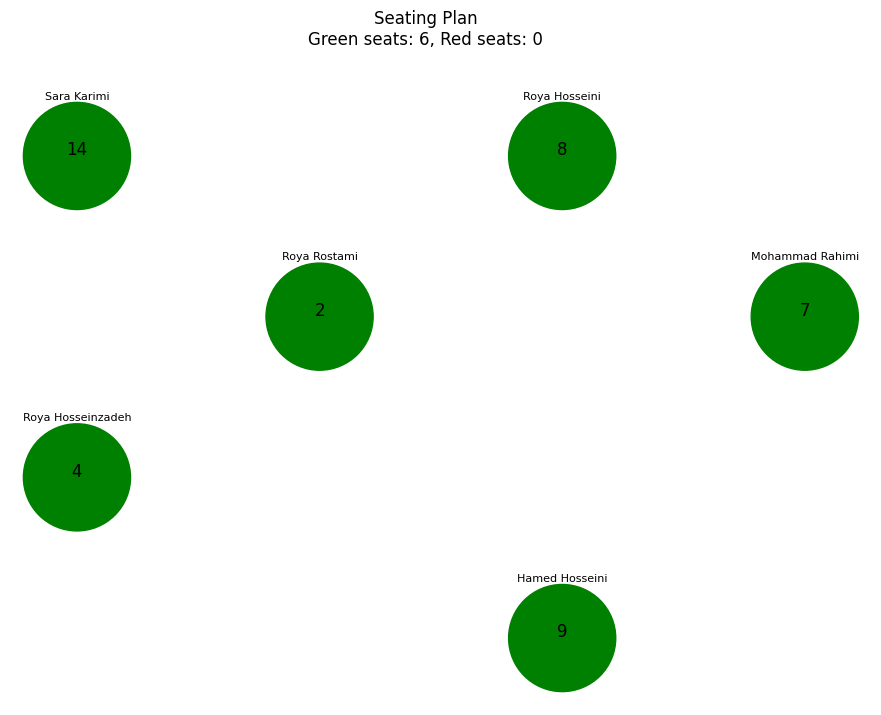

Row Sum Loss: 199.93701171875, Col Sum Loss: 199.9447479248047, Conflict Loss: 1.027677262754878e-05, Group Mate Loss: 46.564292907714844
Row Sum Loss: 199.2385711669922, Col Sum Loss: 199.24642944335938, Conflict Loss: 6.9638608692912385e-06, Group Mate Loss: 47.631141662597656
Row Sum Loss: 198.5965118408203, Col Sum Loss: 198.6042938232422, Conflict Loss: 5.17067883265554e-06, Group Mate Loss: 48.02345657348633
Row Sum Loss: 196.76710510253906, Col Sum Loss: 196.77589416503906, Conflict Loss: 4.4919302126800176e-06, Group Mate Loss: 48.512020111083984
Row Sum Loss: 191.74685668945312, Col Sum Loss: 191.75848388671875, Conflict Loss: 5.414916813606396e-06, Group Mate Loss: 49.73185729980469
Row Sum Loss: 182.9930419921875, Col Sum Loss: 183.01165771484375, Conflict Loss: 9.255692930310033e-06, Group Mate Loss: 52.68048095703125
Row Sum Loss: 179.6633758544922, Col Sum Loss: 179.6918487548828, Conflict Loss: 1.3571335330198053e-05, Group Mate Loss: 55.28133010864258
Row Sum Loss: 179.

<Figure size 640x480 with 0 Axes>

Row Sum Loss: 104.70562744140625, Col Sum Loss: 119.2730712890625, Conflict Loss: 0.006876335013657808, Group Mate Loss: 83.11697387695312
Row Sum Loss: 90.08712005615234, Col Sum Loss: 116.15546417236328, Conflict Loss: 0.022530825808644295, Group Mate Loss: 88.32083129882812
Row Sum Loss: 84.4796371459961, Col Sum Loss: 111.79431915283203, Conflict Loss: 0.08979073166847229, Group Mate Loss: 95.45733642578125
Row Sum Loss: 78.27714538574219, Col Sum Loss: 107.90333557128906, Conflict Loss: 0.1804252564907074, Group Mate Loss: 95.4942626953125
Row Sum Loss: 76.64509582519531, Col Sum Loss: 101.347900390625, Conflict Loss: 0.20249313116073608, Group Mate Loss: 93.82899475097656
Row Sum Loss: 79.10289001464844, Col Sum Loss: 91.11761474609375, Conflict Loss: 0.16630670428276062, Group Mate Loss: 94.55467987060547
Row Sum Loss: 78.05436706542969, Col Sum Loss: 83.23992919921875, Conflict Loss: 0.1723354011774063, Group Mate Loss: 98.82717895507812
Row Sum Loss: 59.16604995727539, Col Sum

<Figure size 640x480 with 0 Axes>

Row Sum Loss: 8.871899604797363, Col Sum Loss: 19.164936065673828, Conflict Loss: 0.21415528655052185, Group Mate Loss: 120.86104583740234
Row Sum Loss: 9.103671073913574, Col Sum Loss: 13.835577011108398, Conflict Loss: 0.3487226963043213, Group Mate Loss: 119.9094009399414
Row Sum Loss: 6.501945972442627, Col Sum Loss: 11.21656322479248, Conflict Loss: 0.6668002605438232, Group Mate Loss: 125.14836883544922
Row Sum Loss: 4.862319469451904, Col Sum Loss: 5.483451843261719, Conflict Loss: 0.35394155979156494, Group Mate Loss: 124.38423919677734
Row Sum Loss: 4.723841667175293, Col Sum Loss: 1.781476616859436, Conflict Loss: 0.2317577451467514, Group Mate Loss: 125.51261901855469
Row Sum Loss: 6.195991039276123, Col Sum Loss: 2.134763717651367, Conflict Loss: 0.24843022227287292, Group Mate Loss: 124.08040618896484
Row Sum Loss: 7.38178825378418, Col Sum Loss: 3.8950839042663574, Conflict Loss: 0.1369345635175705, Group Mate Loss: 119.14883422851562
Row Sum Loss: 2.1059350967407227, Col

<Figure size 640x480 with 0 Axes>

Row Sum Loss: 15.736368179321289, Col Sum Loss: 15.57354736328125, Conflict Loss: 0.002776648150756955, Group Mate Loss: 110.91551208496094
Row Sum Loss: 3.8315584659576416, Col Sum Loss: 2.792386054992676, Conflict Loss: 0.0038678257260471582, Group Mate Loss: 125.10660552978516
Row Sum Loss: 2.0461318492889404, Col Sum Loss: 2.335310459136963, Conflict Loss: 0.0028613777831196785, Group Mate Loss: 123.58504486083984
Row Sum Loss: 4.888113975524902, Col Sum Loss: 7.245955944061279, Conflict Loss: 0.0019450740655884147, Group Mate Loss: 117.81204223632812
Row Sum Loss: 5.000487327575684, Col Sum Loss: 6.26298713684082, Conflict Loss: 0.0018750674789771438, Group Mate Loss: 117.07256317138672
Row Sum Loss: 2.698122978210449, Col Sum Loss: 1.935335397720337, Conflict Loss: 0.0023542901035398245, Group Mate Loss: 121.2345199584961
Row Sum Loss: 2.6678667068481445, Col Sum Loss: 2.9631786346435547, Conflict Loss: 0.0023727796506136656, Group Mate Loss: 121.26618957519531
Row Sum Loss: 4.09

<Figure size 640x480 with 0 Axes>

Row Sum Loss: 34.13294219970703, Col Sum Loss: 36.6820068359375, Conflict Loss: 0.0010044336086139083, Group Mate Loss: 102.13446807861328
Row Sum Loss: 8.27393913269043, Col Sum Loss: 8.876092910766602, Conflict Loss: 0.0012359513202682137, Group Mate Loss: 115.7814712524414
Row Sum Loss: 1.4612972736358643, Col Sum Loss: 0.70368492603302, Conflict Loss: 0.0009664500830695033, Group Mate Loss: 124.55229187011719
Row Sum Loss: 1.5276477336883545, Col Sum Loss: 0.51180100440979, Conflict Loss: 0.0008014196646399796, Group Mate Loss: 125.44046020507812
Row Sum Loss: 1.2345184087753296, Col Sum Loss: 0.8509934544563293, Conflict Loss: 0.0006672610761597753, Group Mate Loss: 125.44725799560547
Row Sum Loss: 0.6226761937141418, Col Sum Loss: 0.6276038885116577, Conflict Loss: 0.0005454567144624889, Group Mate Loss: 125.6923828125
Row Sum Loss: 0.7794957160949707, Col Sum Loss: 0.8498951196670532, Conflict Loss: 0.00042790817678906024, Group Mate Loss: 125.2420883178711
Row Sum Loss: 1.04609

<Figure size 640x480 with 0 Axes>

Row Sum Loss: 20.13189697265625, Col Sum Loss: 20.83411979675293, Conflict Loss: 0.0030991663224995136, Group Mate Loss: 120.67762756347656
Row Sum Loss: 7.422778129577637, Col Sum Loss: 10.451140403747559, Conflict Loss: 0.0018525089835748076, Group Mate Loss: 124.5396957397461
Row Sum Loss: 1.382946252822876, Col Sum Loss: 2.4649531841278076, Conflict Loss: 0.0014137860853224993, Group Mate Loss: 131.1295928955078
Row Sum Loss: 0.15126417577266693, Col Sum Loss: 0.13937294483184814, Conflict Loss: 0.0006895033875480294, Group Mate Loss: 128.91915893554688
Row Sum Loss: 0.008708926849067211, Col Sum Loss: 0.018016431480646133, Conflict Loss: 0.0003934965352527797, Group Mate Loss: 128.16665649414062
Row Sum Loss: 0.005518693942576647, Col Sum Loss: 0.013390712440013885, Conflict Loss: 0.00023324723588302732, Group Mate Loss: 127.82926940917969
Row Sum Loss: 0.05571609362959862, Col Sum Loss: 0.06110244244337082, Conflict Loss: 0.00014511402696371078, Group Mate Loss: 127.4711227416992

<Figure size 640x480 with 0 Axes>

Row Sum Loss: 3.9157369136810303, Col Sum Loss: 3.9074385166168213, Conflict Loss: 1.0444608733450877e-06, Group Mate Loss: 120.62686157226562
Row Sum Loss: 0.9196721911430359, Col Sum Loss: 0.9135849475860596, Conflict Loss: 1.1953246712437249e-06, Group Mate Loss: 123.83623504638672
Row Sum Loss: 0.6172228455543518, Col Sum Loss: 0.6140275597572327, Conflict Loss: 1.2530314279501908e-06, Group Mate Loss: 124.62970733642578
Row Sum Loss: 0.7072832584381104, Col Sum Loss: 0.7063096761703491, Conflict Loss: 1.1996625062238309e-06, Group Mate Loss: 124.43276977539062
Row Sum Loss: 0.958178699016571, Col Sum Loss: 0.9595414996147156, Conflict Loss: 1.072714667316177e-06, Group Mate Loss: 123.7350845336914
Row Sum Loss: 1.570936679840088, Col Sum Loss: 1.575103521347046, Conflict Loss: 9.233404512087873e-07, Group Mate Loss: 122.50340270996094
Row Sum Loss: 1.797170639038086, Col Sum Loss: 1.8004916906356812, Conflict Loss: 8.422927066931152e-07, Group Mate Loss: 122.05247497558594
Row Sum

<Figure size 640x480 with 0 Axes>

Row Sum Loss: 0.03102174401283264, Col Sum Loss: 0.03101876936852932, Conflict Loss: 2.450655983921024e-06, Group Mate Loss: 127.55296325683594
Row Sum Loss: 0.12677229940891266, Col Sum Loss: 0.12676948308944702, Conflict Loss: 2.2638678274233826e-06, Group Mate Loss: 127.22604370117188
Row Sum Loss: 0.6135316491127014, Col Sum Loss: 0.6135282516479492, Conflict Loss: 2.001288976316573e-06, Group Mate Loss: 126.44734954833984
Row Sum Loss: 0.4390000104904175, Col Sum Loss: 0.43899640440940857, Conflict Loss: 1.8492999060981674e-06, Group Mate Loss: 126.65497589111328
Row Sum Loss: 0.16843052208423615, Col Sum Loss: 0.1684270203113556, Conflict Loss: 1.7189634036185453e-06, Group Mate Loss: 127.0894775390625
Row Sum Loss: 0.0802924856543541, Col Sum Loss: 0.08028912544250488, Conflict Loss: 1.5591767805744894e-06, Group Mate Loss: 127.27753448486328
Row Sum Loss: 0.06466177105903625, Col Sum Loss: 0.06465814262628555, Conflict Loss: 1.3496226074494189e-06, Group Mate Loss: 127.25198364

<Figure size 640x480 with 0 Axes>

Row Sum Loss: 3.586637496948242, Col Sum Loss: 3.5866191387176514, Conflict Loss: 8.626774956610461e-07, Group Mate Loss: 121.72306823730469
Row Sum Loss: 0.31697747111320496, Col Sum Loss: 0.31696009635925293, Conflict Loss: 9.102492413148866e-07, Group Mate Loss: 125.74476623535156
Row Sum Loss: 0.2046048790216446, Col Sum Loss: 0.20458577573299408, Conflict Loss: 8.34313425457367e-07, Group Mate Loss: 126.35442352294922
Row Sum Loss: 0.3695656657218933, Col Sum Loss: 0.3695434033870697, Conflict Loss: 6.737006401635881e-07, Group Mate Loss: 125.96881866455078
Row Sum Loss: 0.9016844630241394, Col Sum Loss: 0.9016594886779785, Conflict Loss: 4.806323090633668e-07, Group Mate Loss: 124.8855209350586
Row Sum Loss: 1.3125531673431396, Col Sum Loss: 1.3125293254852295, Conflict Loss: 3.672747652672115e-07, Group Mate Loss: 124.23639678955078
Row Sum Loss: 0.6810662746429443, Col Sum Loss: 0.6810479164123535, Conflict Loss: 3.516287279126118e-07, Group Mate Loss: 125.21003723144531
Row Su

<Figure size 640x480 with 0 Axes>

Row Sum Loss: 0.18727898597717285, Col Sum Loss: 0.18550080060958862, Conflict Loss: 1.5220321358810907e-07, Group Mate Loss: 126.68888092041016
Row Sum Loss: 0.5702041387557983, Col Sum Loss: 0.5672340393066406, Conflict Loss: 9.884973195539715e-08, Group Mate Loss: 125.85812377929688
Row Sum Loss: 0.5506098866462708, Col Sum Loss: 0.5492405891418457, Conflict Loss: 7.772820964646598e-08, Group Mate Loss: 125.6617202758789
Row Sum Loss: 0.7105105519294739, Col Sum Loss: 0.7098675966262817, Conflict Loss: 5.954147752618155e-08, Group Mate Loss: 125.2154312133789
Row Sum Loss: 0.9687184691429138, Col Sum Loss: 0.968267023563385, Conflict Loss: 4.5642426726999474e-08, Group Mate Loss: 124.57844543457031
Row Sum Loss: 1.2283236980438232, Col Sum Loss: 1.2279492616653442, Conflict Loss: 4.1514088167105e-08, Group Mate Loss: 124.20539855957031
Row Sum Loss: 0.6044345498085022, Col Sum Loss: 0.6041358709335327, Conflict Loss: 4.96244219050368e-08, Group Mate Loss: 125.2697982788086
Row Sum L

<Figure size 640x480 with 0 Axes>

Row Sum Loss: 0.9076565504074097, Col Sum Loss: 0.9076440334320068, Conflict Loss: 2.032340695734547e-08, Group Mate Loss: 124.47626495361328
Row Sum Loss: 0.7271500825881958, Col Sum Loss: 0.7271392345428467, Conflict Loss: 1.8942584389947115e-08, Group Mate Loss: 124.61885070800781
Row Sum Loss: 0.920150876045227, Col Sum Loss: 0.9201409816741943, Conflict Loss: 1.559477880164195e-08, Group Mate Loss: 124.08647918701172
Row Sum Loss: 1.5529788732528687, Col Sum Loss: 1.5529686212539673, Conflict Loss: 1.225629375767312e-08, Group Mate Loss: 122.93672180175781
Row Sum Loss: 1.1507041454315186, Col Sum Loss: 1.1506950855255127, Conflict Loss: 1.3333765203071835e-08, Group Mate Loss: 123.54251861572266
Row Sum Loss: 0.7305799722671509, Col Sum Loss: 0.7305728197097778, Conflict Loss: 1.4670283654538707e-08, Group Mate Loss: 124.24740600585938
Row Sum Loss: 0.840173602104187, Col Sum Loss: 0.8401668071746826, Conflict Loss: 1.2653293524067522e-08, Group Mate Loss: 123.82135009765625
Row 

<Figure size 640x480 with 0 Axes>

Row Sum Loss: 2.238558292388916, Col Sum Loss: 2.238553524017334, Conflict Loss: 9.516817556232127e-09, Group Mate Loss: 121.47004699707031
Row Sum Loss: 0.7310454845428467, Col Sum Loss: 0.7310423254966736, Conflict Loss: 1.4574739637396306e-08, Group Mate Loss: 123.97899627685547
Row Sum Loss: 0.8416825532913208, Col Sum Loss: 0.8416798710823059, Conflict Loss: 1.6261948232454415e-08, Group Mate Loss: 123.88926696777344
Row Sum Loss: 1.4882941246032715, Col Sum Loss: 1.4882912635803223, Conflict Loss: 1.4239472712063161e-08, Group Mate Loss: 122.7286605834961
Row Sum Loss: 1.4567662477493286, Col Sum Loss: 1.456762433052063, Conflict Loss: 1.2881552713395195e-08, Group Mate Loss: 122.71945190429688
Row Sum Loss: 1.0573632717132568, Col Sum Loss: 1.0573599338531494, Conflict Loss: 1.3045886149143371e-08, Group Mate Loss: 123.51408386230469
Row Sum Loss: 0.794619083404541, Col Sum Loss: 0.7946160435676575, Conflict Loss: 1.3223997008537935e-08, Group Mate Loss: 123.98387145996094
Row S

<Figure size 640x480 with 0 Axes>

Row Sum Loss: 0.08470014482736588, Col Sum Loss: 0.08472101390361786, Conflict Loss: 1.188575311061868e-06, Group Mate Loss: 127.46404266357422
Row Sum Loss: 0.11895965784788132, Col Sum Loss: 0.11897877603769302, Conflict Loss: 1.510985498498485e-06, Group Mate Loss: 127.36824035644531
Row Sum Loss: 0.21482281386852264, Col Sum Loss: 0.21484118700027466, Conflict Loss: 1.947991904671653e-06, Group Mate Loss: 127.1544189453125
Row Sum Loss: 0.34253332018852234, Col Sum Loss: 0.3425508439540863, Conflict Loss: 2.3887782845122274e-06, Group Mate Loss: 126.93419647216797
Row Sum Loss: 0.23286370933055878, Col Sum Loss: 0.23287825286388397, Conflict Loss: 2.436835075059207e-06, Group Mate Loss: 127.11902618408203
Row Sum Loss: 0.14506793022155762, Col Sum Loss: 0.14507965743541718, Conflict Loss: 2.4573780592618277e-06, Group Mate Loss: 127.30206298828125
Row Sum Loss: 0.11952164769172668, Col Sum Loss: 0.11953169107437134, Conflict Loss: 2.4972950996016152e-06, Group Mate Loss: 127.364395

<Figure size 640x480 with 0 Axes>

Row Sum Loss: 0.06878701597452164, Col Sum Loss: 0.06878593564033508, Conflict Loss: 1.0774650718303747e-06, Group Mate Loss: 127.32685852050781
Row Sum Loss: 0.07914596050977707, Col Sum Loss: 0.07914524525403976, Conflict Loss: 8.852977657625161e-07, Group Mate Loss: 127.27923583984375
Row Sum Loss: 0.13994143903255463, Col Sum Loss: 0.13994058966636658, Conflict Loss: 6.393798344106472e-07, Group Mate Loss: 127.04464721679688
Row Sum Loss: 0.3460123836994171, Col Sum Loss: 0.3460112512111664, Conflict Loss: 4.1044097542908275e-07, Group Mate Loss: 126.4972152709961
Row Sum Loss: 0.8284875154495239, Col Sum Loss: 0.8284857869148254, Conflict Loss: 2.5943023729269044e-07, Group Mate Loss: 125.64566802978516
Row Sum Loss: 0.7542635202407837, Col Sum Loss: 0.7542619705200195, Conflict Loss: 2.310289630713669e-07, Group Mate Loss: 125.70783996582031
Row Sum Loss: 0.3671565651893616, Col Sum Loss: 0.3671552240848541, Conflict Loss: 2.5992309815592307e-07, Group Mate Loss: 126.364944458007

<Figure size 640x480 with 0 Axes>

Row Sum Loss: 8.965475082397461, Col Sum Loss: 8.965503692626953, Conflict Loss: 1.1730190152547948e-07, Group Mate Loss: 118.49732971191406
Row Sum Loss: 0.04226754605770111, Col Sum Loss: 0.04226680472493172, Conflict Loss: 6.230021085684712e-07, Group Mate Loss: 127.278564453125
Row Sum Loss: 0.002180962124839425, Col Sum Loss: 0.002175436820834875, Conflict Loss: 2.2299750526144635e-06, Group Mate Loss: 127.86160278320312
Row Sum Loss: 0.00023922516265884042, Col Sum Loss: 0.0002348094858461991, Conflict Loss: 6.8823728724964894e-06, Group Mate Loss: 127.96171569824219
Row Sum Loss: 3.799932528636418e-05, Col Sum Loss: 3.573712092475034e-05, Conflict Loss: 1.836591400206089e-05, Group Mate Loss: 127.99639892578125
Row Sum Loss: 3.988920070696622e-05, Col Sum Loss: 4.0487615478923544e-05, Conflict Loss: 3.48565008607693e-05, Group Mate Loss: 128.01910400390625
Row Sum Loss: 0.00013483357906807214, Col Sum Loss: 0.00015832704957574606, Conflict Loss: 5.910720938118175e-05, Group Mate

<Figure size 640x480 with 0 Axes>

Row Sum Loss: 6.078799685838021e-08, Col Sum Loss: 5.5056901260286395e-08, Conflict Loss: 1.161852878794889e-06, Group Mate Loss: 128.00009155273438
Row Sum Loss: 5.0680384333645634e-08, Col Sum Loss: 4.72397232442745e-08, Conflict Loss: 8.835830840325798e-07, Group Mate Loss: 127.99996185302734
Row Sum Loss: 4.578467382998497e-08, Col Sum Loss: 4.386080831864092e-08, Conflict Loss: 6.7504180378819e-07, Group Mate Loss: 127.99984741210938
Row Sum Loss: 4.444828505256737e-08, Col Sum Loss: 4.331852210270881e-08, Conflict Loss: 5.196887968850206e-07, Group Mate Loss: 127.99974822998047
Row Sum Loss: 4.573230683035945e-08, Col Sum Loss: 4.486274463033624e-08, Conflict Loss: 4.036684515540401e-07, Group Mate Loss: 127.99964904785156
Row Sum Loss: 4.954486598762742e-08, Col Sum Loss: 4.8739963176558376e-08, Conflict Loss: 3.165504267599317e-07, Group Mate Loss: 127.99957275390625
Row Sum Loss: 5.607738273738505e-08, Col Sum Loss: 5.554248616590485e-08, Conflict Loss: 2.5059159725060454e-07,

<Figure size 640x480 with 0 Axes>

Row Sum Loss: 0.00029565198929049075, Col Sum Loss: 0.00029564305441454053, Conflict Loss: 2.270122578806877e-08, Group Mate Loss: 127.96379852294922
Row Sum Loss: 0.0010629588505253196, Col Sum Loss: 0.0010629419703036547, Conflict Loss: 1.9678276785839444e-08, Group Mate Loss: 127.93416595458984
Row Sum Loss: 0.004503574687987566, Col Sum Loss: 0.004503575619310141, Conflict Loss: 1.6741589448088234e-08, Group Mate Loss: 127.8691635131836
Row Sum Loss: 0.02429014816880226, Col Sum Loss: 0.024290144443511963, Conflict Loss: 1.3665201414880812e-08, Group Mate Loss: 127.70459747314453
Row Sum Loss: 0.18567043542861938, Col Sum Loss: 0.18567043542861938, Conflict Loss: 1.0313940812523015e-08, Group Mate Loss: 127.20063018798828
Row Sum Loss: 1.174696922302246, Col Sum Loss: 1.174696922302246, Conflict Loss: 7.75454545021148e-09, Group Mate Loss: 126.00907135009766
Row Sum Loss: 0.02554647997021675, Col Sum Loss: 0.025546478107571602, Conflict Loss: 1.5623527360730805e-08, Group Mate Loss

<Figure size 640x480 with 0 Axes>

Row Sum Loss: 0.02457503415644169, Col Sum Loss: 0.024574488401412964, Conflict Loss: 2.256638481412665e-06, Group Mate Loss: 127.6998519897461
Row Sum Loss: 0.0665549635887146, Col Sum Loss: 0.06655440479516983, Conflict Loss: 1.7894720940603293e-06, Group Mate Loss: 127.51266479492188
Row Sum Loss: 0.27727359533309937, Col Sum Loss: 0.27727311849594116, Conflict Loss: 1.2820686379200197e-06, Group Mate Loss: 127.02215576171875
Row Sum Loss: 0.6178050637245178, Col Sum Loss: 0.617805004119873, Conflict Loss: 1.0157762062590336e-06, Group Mate Loss: 126.54542541503906
Row Sum Loss: 0.11544172465801239, Col Sum Loss: 0.11544069647789001, Conflict Loss: 1.3272439218781074e-06, Group Mate Loss: 127.33943176269531
Row Sum Loss: 0.035939350724220276, Col Sum Loss: 0.035937804728746414, Conflict Loss: 1.5473199255211512e-06, Group Mate Loss: 127.60105895996094
Row Sum Loss: 0.022911960259079933, Col Sum Loss: 0.02290976420044899, Conflict Loss: 1.574368297951878e-06, Group Mate Loss: 127.656

<Figure size 640x480 with 0 Axes>

Row Sum Loss: 0.23387280106544495, Col Sum Loss: 0.23386098444461823, Conflict Loss: 6.096146876188868e-07, Group Mate Loss: 126.80120849609375
Row Sum Loss: 0.1987960934638977, Col Sum Loss: 0.19878387451171875, Conflict Loss: 6.498289621958975e-07, Group Mate Loss: 126.91475677490234
Row Sum Loss: 0.2333633303642273, Col Sum Loss: 0.23335067927837372, Conflict Loss: 6.093289925956924e-07, Group Mate Loss: 126.82221221923828
Row Sum Loss: 0.34763994812965393, Col Sum Loss: 0.3476271629333496, Conflict Loss: 5.14884845870256e-07, Group Mate Loss: 126.53305053710938
Row Sum Loss: 0.5747747421264648, Col Sum Loss: 0.5747622847557068, Conflict Loss: 4.175694243713224e-07, Group Mate Loss: 126.08238220214844
Row Sum Loss: 0.6451067328453064, Col Sum Loss: 0.6450957655906677, Conflict Loss: 3.9197826140480174e-07, Group Mate Loss: 125.97991180419922
Row Sum Loss: 0.3533855080604553, Col Sum Loss: 0.3533751964569092, Conflict Loss: 4.6363314254449506e-07, Group Mate Loss: 126.4981460571289
R

<Figure size 640x480 with 0 Axes>

In [787]:
# Training loop

# %matplotlib qt
from IPython.display import display, clear_output

LOSS=0.0001

num_epochs = 400
train_input = torch.arange(Nof_users, dtype=torch.float32)

seating_arrangements = []

# Create a new figure and axes
fig, ax = plt.subplots(Rows,  Colums, figsize=(12, 8))
#fig.suptitle('Seating Plan')

New_input = train_input
for epoch in range(num_epochs):
    optimizer.zero_grad()
    perm_matrix = model(New_input)
    loss = custom_loss(output=perm_matrix,pairwise_conflicts=pairwise_conflicts,seat_rows= Rows,seat_cols =Colums,high_importance=20.0,groups=grups, group_penalty = 1,conflict_penalty=1)
    loss.backward()
    optimizer.step()

    # Add noise to the weights every 500 epochs
    if (epoch + 1) % 50 == 0:
        add_noise_to_weights(model, noise_factor=0.01)

    if (epoch + 1) % 20 == 0:
        # visualize every 100 epoch
        final_perm_matrix = model(train_input)

        # Thresholding
        threshold = 0.5
        perm_matrix_flat = (final_perm_matrix > threshold).float().flatten()

        # Find indices where perm_matrix_flat is 1
        indices = perm_matrix_flat.nonzero().squeeze()

        # Convert indices to numbers between 0 and 23
        positions = indices % Nof_users

        # Create New_input tensor with all numbers from 0 to 23
        New_input = torch.arange(Nof_users, dtype=torch.float32)

        # Determine missing numbers not generated in output
        missing_numbers = list(set(range(Nof_users)) - set(positions.tolist()))
        random.shuffle(missing_numbers)

        # Replace positions with actual output values and missing positions with random missing numbers
        for i in range(Nof_users):
            if i < len(positions):
                New_input[i] = positions[i]
            else:
                New_input[i] = missing_numbers.pop()

        #print(New_input)



        seat_arrangement = print_person_seat_assignments(final_perm_matrix)
        #animate_seating_arrangement(seat_arrangement, pairwise_conflicts, full_names, fig, ax)
        green_count, red_count = animate_seating_arrangement(seat_arrangement, pairwise_conflicts, full_names, fig, ax)
        if green_count ==Nof_users:
            print(f'All seats are correctly assinged, Loss = ', loss.item())
            break

    # Stop training by reaching to desirable loss
    if loss.item() <= LOSS:
        print(f'Loss reached below {LOSS} Breaking the loop: ', loss.item())
        break

    # if (epoch + 1) % 20 == 0:
    #     print(f'Epoch [{epoch+1}/{num_epochs}], total_loss: {loss.item()}')
    #     for txt in fig.texts:
    #         if txt.get_text().startswith('Epoch'):
    #             txt.remove()
    #     fig.text(0.1, 0.05, f'Epoch [{epoch+1}/{num_epochs}], total_loss: {loss.item()}', fontsize=10, ha='left')


# Keep the window open until it's closed manually
plt.show()


In [788]:
# Add noise to the weights if needed
add_noise_to_weights(model, noise_factor=0.05)

# Lowering learning rate if needed
for param_group in optimizer.param_groups:
    param_group['lr'] = 0.0001  # Set the learning rate to a new value (e.g., 0.0001)


In [789]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_seating_arrangement(person_seat_assignments, pairwise_conflicts, full_names, groups):
    """
    Visualizes the seating arrangement in a 4x6 grid with circles representing persons.
    If two persons with conflicts are sitting next to each other (right, left, top, or down),
    their circles will be red. Persons in the same group will have a different color.

    Args:
        person_seat_assignments (list): A list of tuples where each tuple is (person, seat).
        pairwise_conflicts (torch.Tensor): A 24x24 tensor where 0 means no conflict, and 1 means conflict.
        full_names (list): A list containing the full names for each person.
        groups (list of lists): A list of lists where each inner list contains indices of persons in the same group.
    """
    fig, ax = plt.subplots(Rows, Colums, figsize=(12, 8))
    fig.suptitle('Seating Plan')
    # Clear the axes
    for a in ax.flat:
        a.clear()

    seat_person_map = {seat: person for person, seat in person_seat_assignments}

    ax_array = np.empty((Rows, Colums), dtype=object)

    # Define a color map for groups
    group_colors = ['blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan','gray', 'black']

    for i in range(Rows):
        for j in range(Colums):
            seat = i * Colums + j
            person = seat_person_map.get(seat)
            color = 'white'  # default color
            radius = 0.4  # default radius

            if person is not None:
                # Determine the color based on conflicts and group membership
                adjacent_seats = [
                    seat - 1 if j > 0 else None,  # Left
                    seat + 1 if j < Colums-1 else None,  # Right
                    seat - Colums if i > 0 else None,  # Top
                    seat + Colums if i < Rows-1 else None,  # Down
                ]

                # Find the group index for the person
                person_group_index = None
                for idx, group in enumerate(groups):
                    if person in group:
                        person_group_index = idx
                        break

                if person_group_index is not None:
                    color = group_colors[person_group_index]

                for adjacent_seat in adjacent_seats:
                    if adjacent_seat is not None:
                        adjacent_person = seat_person_map.get(adjacent_seat)
                        if adjacent_person is not None:
                            conflict = pairwise_conflicts[person, adjacent_person].item()
                            if conflict == -10:
                                color = 'red'
                                radius = 0.5
                                break

            if person is not None:
                ax[i, j].add_patch(plt.Circle((0.5, 0.5), radius, color=color))
                ax[i, j].text(0.5, 0.55, str(person), ha='center', va='center', fontsize=12)
                ax[i, j].text(0.5, 0.95, full_names[person], ha='center', va='center', fontsize=8)
                ax_array[i, j] = str(person)

            ax[i, j].set_aspect('equal')
            ax[i, j].axis('off')

    plt.show()
    return ax_array


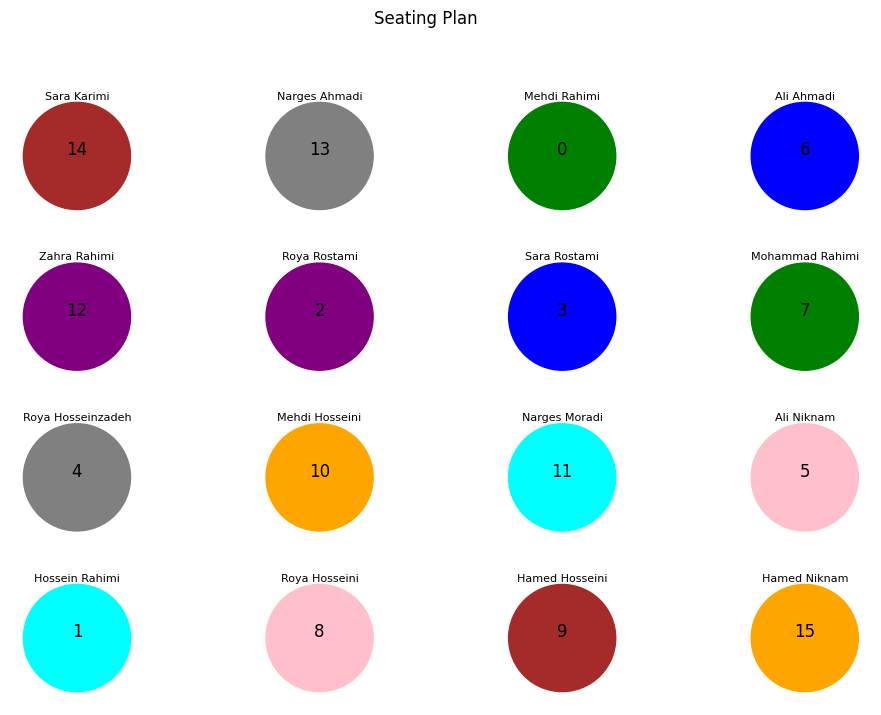

In [790]:
# Final output
%matplotlib inline
from IPython.display import display


final_perm_matrix = model(train_input)
# seat_arrangement = print_person_seat_assignments(final_perm_matrix)
# usage:
best_seating=visualize_seating_arrangement(seat_arrangement, pairwise_conflicts, full_names,grups)

